# Training file for UpscaleNN

## Imports

In [1]:
import platform 


device = None
if platform.system() == 'Windows':  # Check if the OS is Windows
    import torch_directml  # Import torch_directml only on Windows
    device = torch_directml.device()
else:
    !pip install -r requirements.txt
    pass


In [2]:
import src.models.nntools as nt

from src.dataset.ImageDatasetPatch import ImageDatasetPatch
from src.dataset.PatchImageTool import PatchImageTool

from src.utils.PytorchUtil import PytorchUtil as torchUtil
from src.utils.PlotUtils import PlotUtils

from src.models.UpscaleResidualNN import UpscaleResidualNN

import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import skimage.metrics as metrics
# Import the platform module to detect the OS

if not device:
    if torch.cuda.is_available():
        device = torch.device('cuda')
        torch.cuda.empty_cache()
    else:
        device = torch.device('cpu')

print(device)

2023-12-24 20:18:56.769970: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-24 20:18:56.800765: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-24 20:18:56.800819: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-24 20:18:56.800847: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-24 20:18:56.807027: I tensorflow/core/platform/cpu_feature_g

cuda


## Training information

In [3]:
SUBSET_SIZE = 100

LR = 1e-5
BATCH_SIZE = 20
PATCH_SIZE = 64

PATH_SAVE_SMALL_MODEL = "results/smallbatchexperiment-upscale-residual-lpips2"
EPOCH_SMALL_MODEL = 200
SMALL_MODEL_USE_LPIPS = True

PATH_SAVE_MODEL = "results/superresol-upscale-resid-lpips2"
EPOCH_MODEL = 10
MODEL_USE_LPIPS = True

UPSCALE_FACTORS = [2, 4, 8]

## Utility function

In [4]:
class SuperResolutionStatsManager(nt.StatsManager):
    def __init__(self):
        super(SuperResolutionStatsManager, self).__init__()

    def init(self):
        super(SuperResolutionStatsManager, self).init()
        # Initializing `self.running_psnr`
        self.running_psnr = 0
        self.running_ssim = 0

    def accumulate(self, loss, x, y, d):
        super(SuperResolutionStatsManager, self).accumulate(loss, x, y, d)
        # Updating `self.running_psnr`
        d_numpy = d.detach().to('cpu').numpy()
        y_numpy = y.detach().to('cpu').numpy()

        self.running_psnr += metrics.peak_signal_noise_ratio(d_numpy, y_numpy)

        current_ssim = 0

        for i in range(d_numpy.shape[0]):
            d_numpy_temp = np.moveaxis(d_numpy[i], [0, 1, 2], [2, 0, 1])
            y_numpy_temp = np.moveaxis(y_numpy[i], [0, 1, 2], [2, 0, 1])

            value_range = max(d_numpy_temp.max(), y_numpy_temp.max()) - min(d_numpy_temp.min(), y_numpy_temp.min())
            
            current_ssim += metrics.structural_similarity(d_numpy_temp, y_numpy_temp, win_size=7, 
                                                          data_range=value_range, multichannel=True, channel_axis=2)
        
        self.running_ssim += current_ssim / d_numpy.shape[0]

    def summarize(self):
        loss = super(SuperResolutionStatsManager, self).summarize()
        psnr = self.running_psnr / (self.number_update+1e-9 )
        ssim = self.running_ssim / (self.number_update+1e-9 )

        return {'loss': loss, 'psnr': psnr, "ssim": ssim}

def criterion(y, d, lpips, lpips_lambda):
    return F.mse_loss(y, d) + lpips(y, d)*lpips_lambda

## Data loader

In [5]:
new_img_size = 256
common_transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

train_transform = transforms.Compose([
    common_transform,
    #transforms.RandomRotation(degrees=10),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    #transforms.RandomResizedCrop(size=(new_img_size, new_img_size), scale=(0.8, 1.0), ratio=(0.75, 1.333)),
])

valid_transform = transforms.Compose([
    common_transform,
    #transforms.CenterCrop((new_img_size, new_img_size)),
])

In [6]:
full_test_dataset = ImageDatasetPatch( "test", "1920x1080", UPSCALE_FACTORS, transforms=train_transform, download=True, patch_size=PATCH_SIZE)
full_train_dataset = ImageDatasetPatch("train", "1920x1080", UPSCALE_FACTORS, transforms=train_transform, download=True, patch_size=PATCH_SIZE)

train_dataset_patched = ImageDatasetPatch("train", "1920x1080", UPSCALE_FACTORS, transforms=train_transform, download=True, patch_size=PATCH_SIZE)
test_dataset_patched = ImageDatasetPatch("test", "1920x1080", UPSCALE_FACTORS, transforms=train_transform, download=True, patch_size=PATCH_SIZE)

full_train_dataset.print_info()

if len(train_dataset_patched) > SUBSET_SIZE:
    train_dataset_patched.limit_dataset(SUBSET_SIZE)

if len(test_dataset_patched) > SUBSET_SIZE * 0.2:
    test_dataset_patched.limit_dataset(int(SUBSET_SIZE * 0.2))

print("Size of sub train dataset", len(train_dataset_patched))
print("Size of sub test dataset", len(test_dataset_patched))

Check for download and resize ...
Check for download and resize ...
Check for download and resize ...
Check for download and resize ...
Number of train high (1920x1080) resolution images: 635
Number of train low (960x540) resolution images: 636
Number of train low (480x270) resolution images: 636
Number of train low (240x135) resolution images: 636
Size of sub train dataset 100
Size of sub test dataset 20


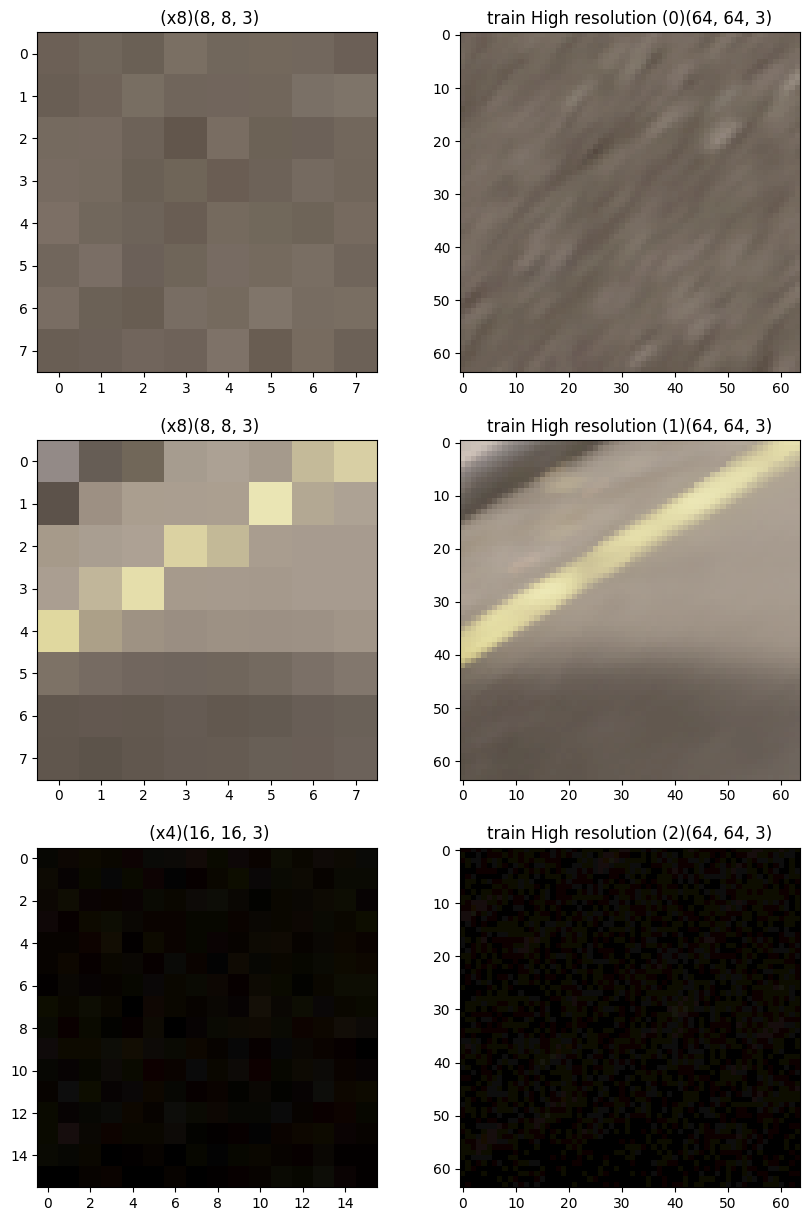

In [7]:
PlotUtils.show_dataset_example(full_train_dataset, num_images=3, width=10)

## Training a model on a small dataset 

In [8]:
small_dataset_size = 30
small_dataset = [train_dataset_patched[np.random.randint(len(train_dataset_patched))] for _ in range(small_dataset_size)]

small_train_size = int(0.8 * len(small_dataset))
small_valid_size = len(small_dataset) - small_train_size
small_train_dataset, small_valid_dataset = torch.utils.data.random_split(small_dataset, [small_train_size, small_valid_size])

"""
redirect all method of list to dataset
"""
class EncapsulatedDataset(list):
    def __init__(self, dataset, upscales):
        self.dataset = dataset
        self.upscales = upscales
    
    def get_upscale_factor(self, index):
        return self.upscales[index]

    def __len__(self):
        return self.dataset.__len__()
    
    def __getitem__(self, index):
        return self.dataset.__getitem__(index)
    
    def __iter__(self):
        return self.dataset.__iter__()
    
    def __next__(self):
        return self.dataset.__next__()
    
    def __str__(self):
        return self.dataset.__str__()
    
    def __repr__(self):
        return self.dataset.__repr__()
    
    def __contains__(self, item):
        return self.dataset.__contains__(item)
    
    def __reversed__(self):
        return self.dataset.__reversed__()
    
    def __add__(self, other):
        return self.dataset.__add__(other)

small_train_dataset = EncapsulatedDataset(small_train_dataset, UPSCALE_FACTORS)
small_valid_dataset = EncapsulatedDataset(small_valid_dataset, UPSCALE_FACTORS)

print("Size of small_train_dataset:", len(small_train_dataset))

Size of small_train_dataset: 24


In [9]:
torch.cuda.empty_cache()

r_small = UpscaleResidualNN(default_upscale_factor=2)
r_small = r_small.to(device)
# In mega bytes
print("Size of model mb", sum(p.numel() for p in r_small.parameters() if p.requires_grad) / (1024 * 1024))

# Size of batch in mega bytes
#print("Size of batch mb", small_dataset[0][0].shape[0] * small_dataset[0][0].shape[1] 
      #* small_dataset[0][0].shape[2] * 4 / (1024 * 1024))

adam = torch.optim.Adam(r_small.parameters(), lr=LR)
stats_manager = SuperResolutionStatsManager()

exp_small = nt.Trainer(r_small, 
                    small_train_dataset, small_valid_dataset, 
                    adam, stats_manager, device, criterion, batch_size=2,
                    output_dir=PATH_SAVE_SMALL_MODEL, perform_validation_during_training=True, 
                    tensor_board=False, use_lpips_loss=SMALL_MODEL_USE_LPIPS)

# Show number of parameters
print("Number of parameters:", sum(p.numel() for p in r_small.parameters() if p.requires_grad))

Size of model mb 0.17946529388427734
Number of parameters: 188183


Start/Continue training from epoch 200
Finish training for 200 epochs


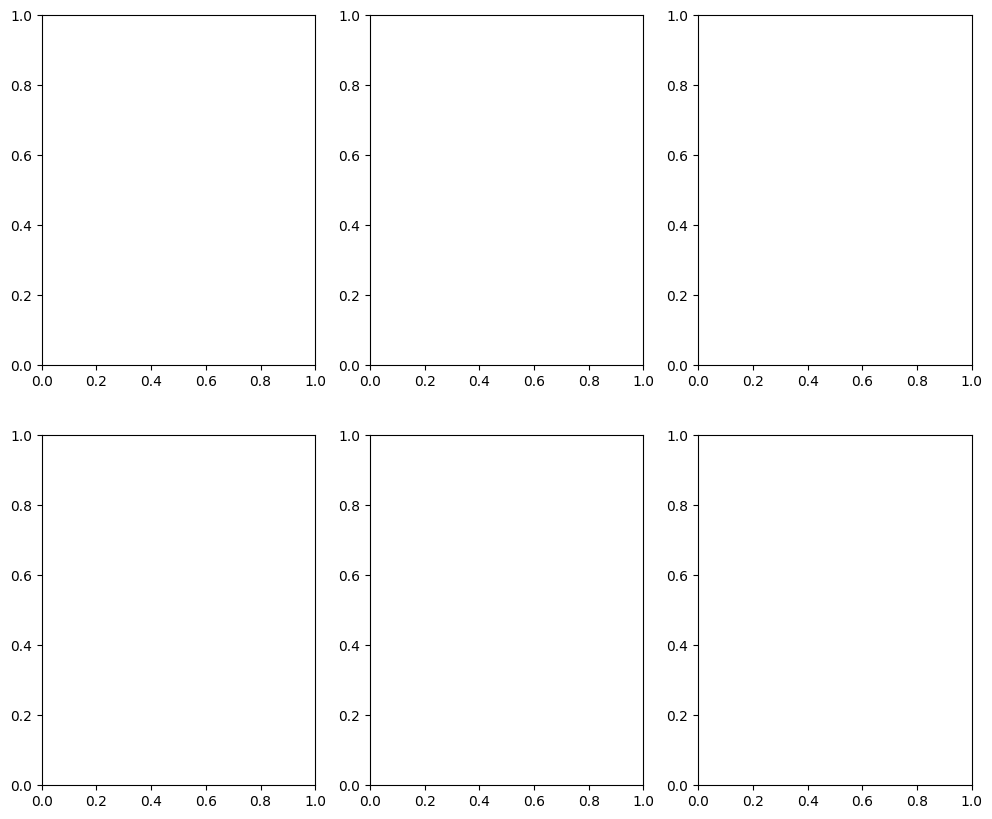

In [10]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 10))
exp_small.run(num_epochs=EPOCH_SMALL_MODEL,
        plot=lambda exp: PlotUtils.plot_images_and_metrics(
                        exp, axes, 
                        small_valid_dataset, np.random.randint(len(small_valid_dataset)), device))

Chosen index 0
Chosen index 1
Chosen index 2


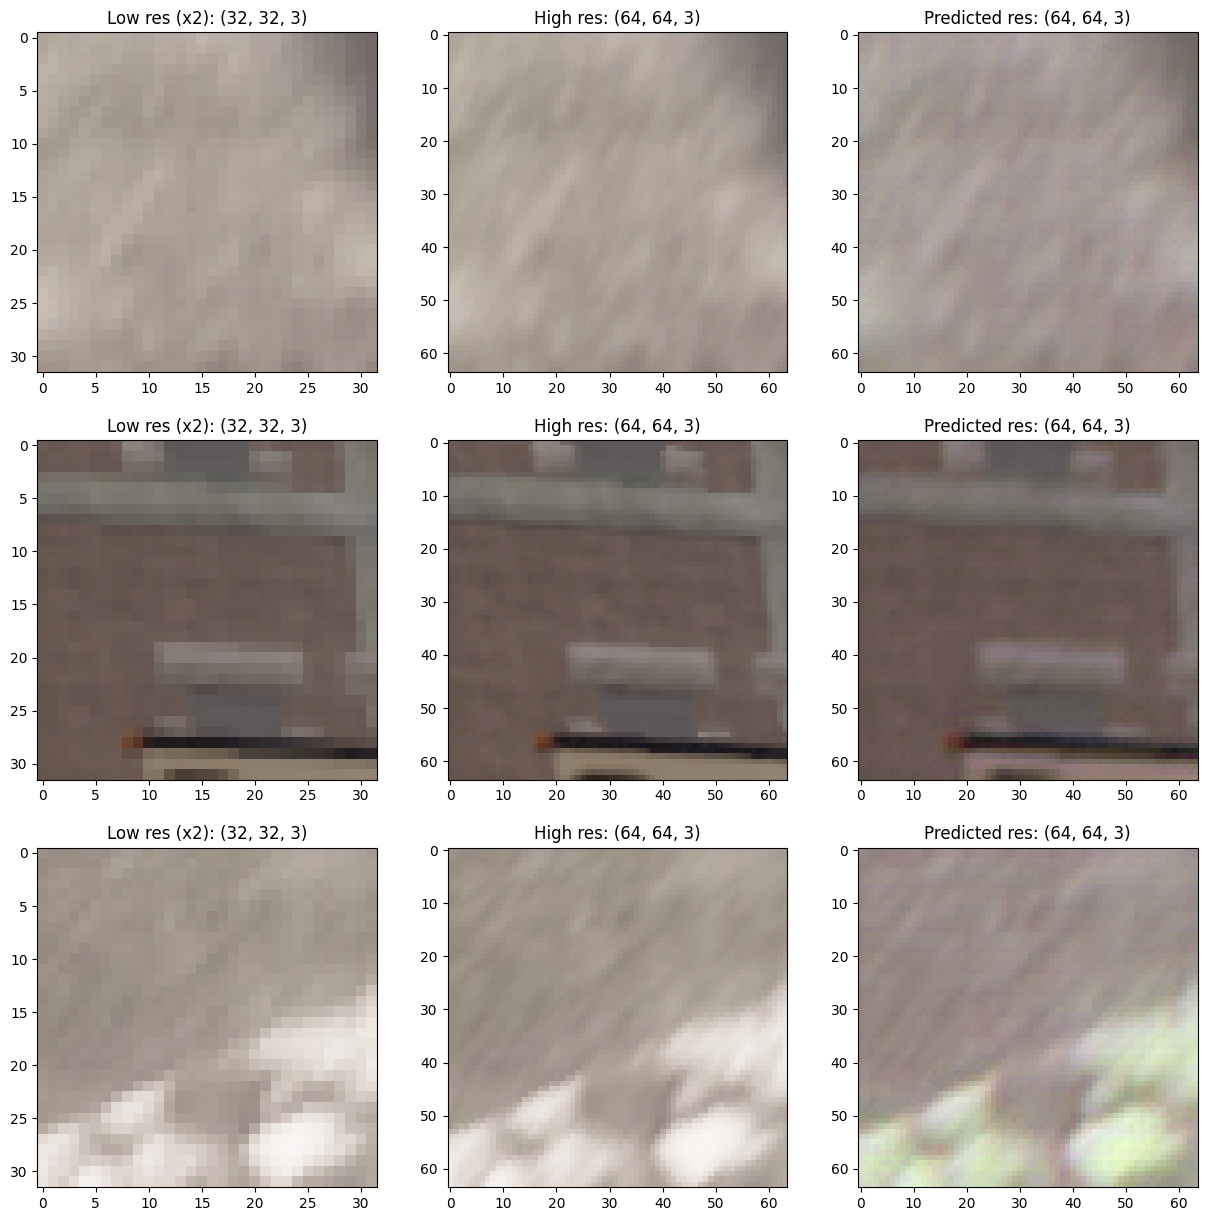

In [11]:
PlotUtils.plot_images_from_model(exp_small, small_train_dataset, device, indices=[0, 1, 2])

Chosen index 0
0.553257 0.13824803
Chosen index 1
0.592362 0.07539591
Chosen index 2
0.6097012 0.11379403


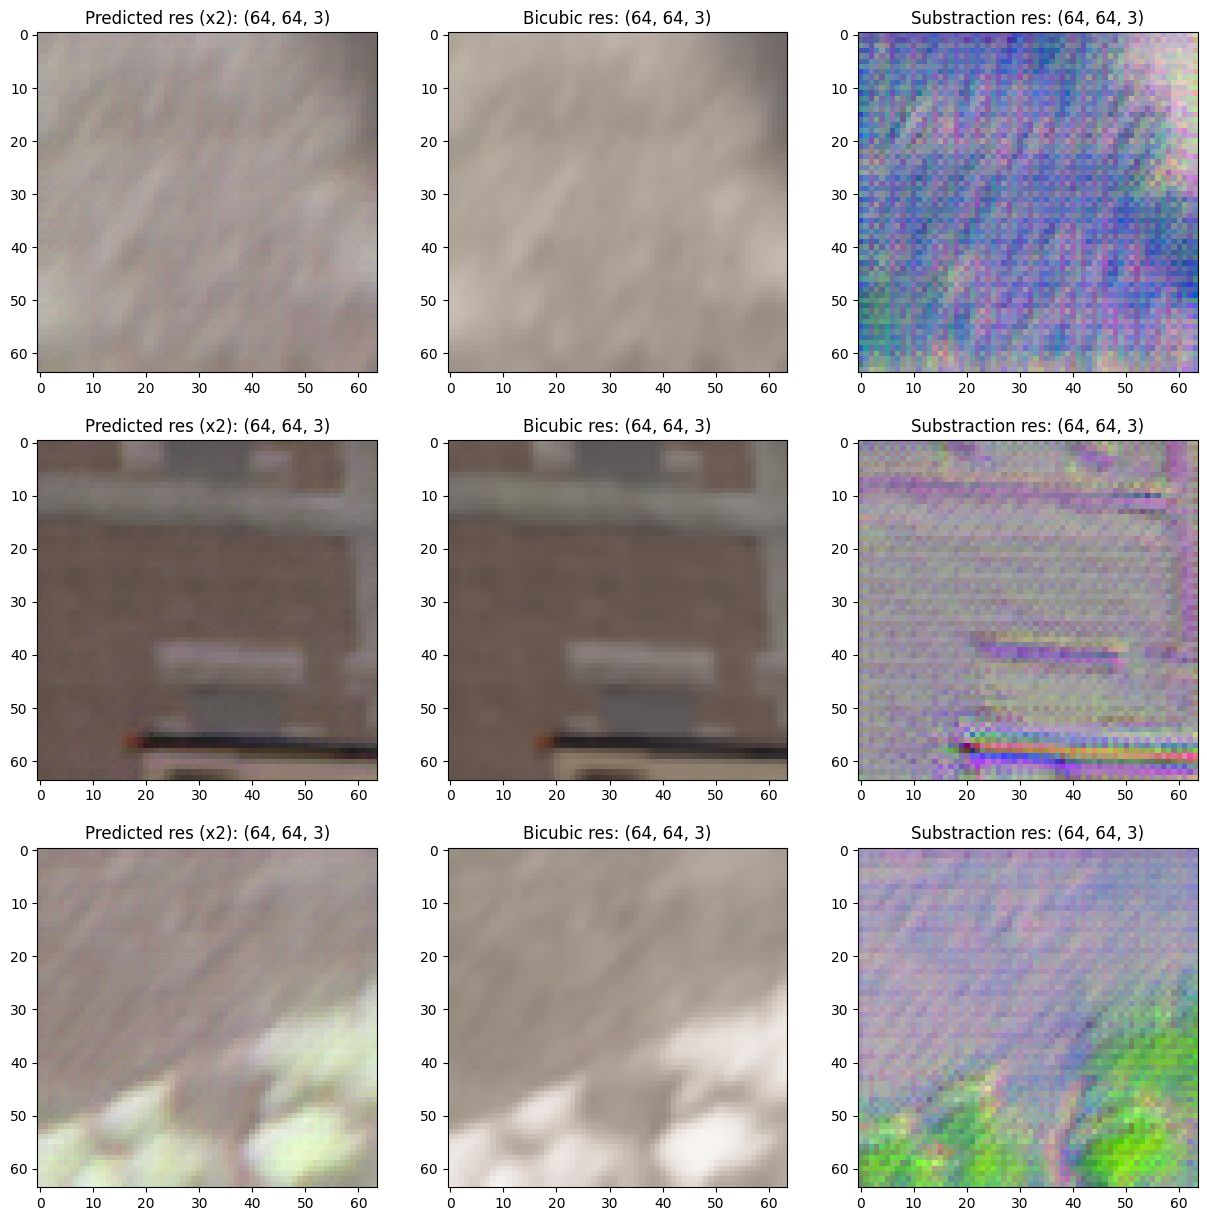

In [12]:
PlotUtils.plot_predicted_and_bicubic(exp_small, small_train_dataset, device, indices=[0, 1, 2])

# Training a model on a subsequent part of the original dataset

In [13]:
# Take the sub part of the dataset from random indices
train_size = int(0.8 * len(train_dataset_patched))
valid_size = len(train_dataset_patched) - train_size

train_sub_dataset, valid_sub_dataset = torch.utils.data.random_split(train_dataset_patched, [train_size, valid_size])

train_sub_dataset = EncapsulatedDataset(train_sub_dataset, UPSCALE_FACTORS)
valid_sub_dataset = EncapsulatedDataset(valid_sub_dataset, UPSCALE_FACTORS)

print("Size of train_dataset: ", len(train_sub_dataset))
print("Size of valid_dataset: ", len(valid_sub_dataset))

Size of train_dataset:  80
Size of valid_dataset:  20


In [14]:
torch.cuda.empty_cache()

r = UpscaleResidualNN(default_upscale_factor=2)
r = r.to(device)

adam = torch.optim.Adam(r.parameters(), lr=LR)
stats_manager = SuperResolutionStatsManager()

exp = nt.Trainer(r, 
                    train_sub_dataset, valid_sub_dataset, 
                    adam, stats_manager, device, criterion, 
                    batch_size=BATCH_SIZE,
                    output_dir=PATH_SAVE_MODEL, perform_validation_during_training=True, 
                    tensor_board=MODEL_USE_LPIPS, use_lpips_loss=False)

Start/Continue training from epoch 0


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 64 but got size 256 for tensor number 1 in the list.

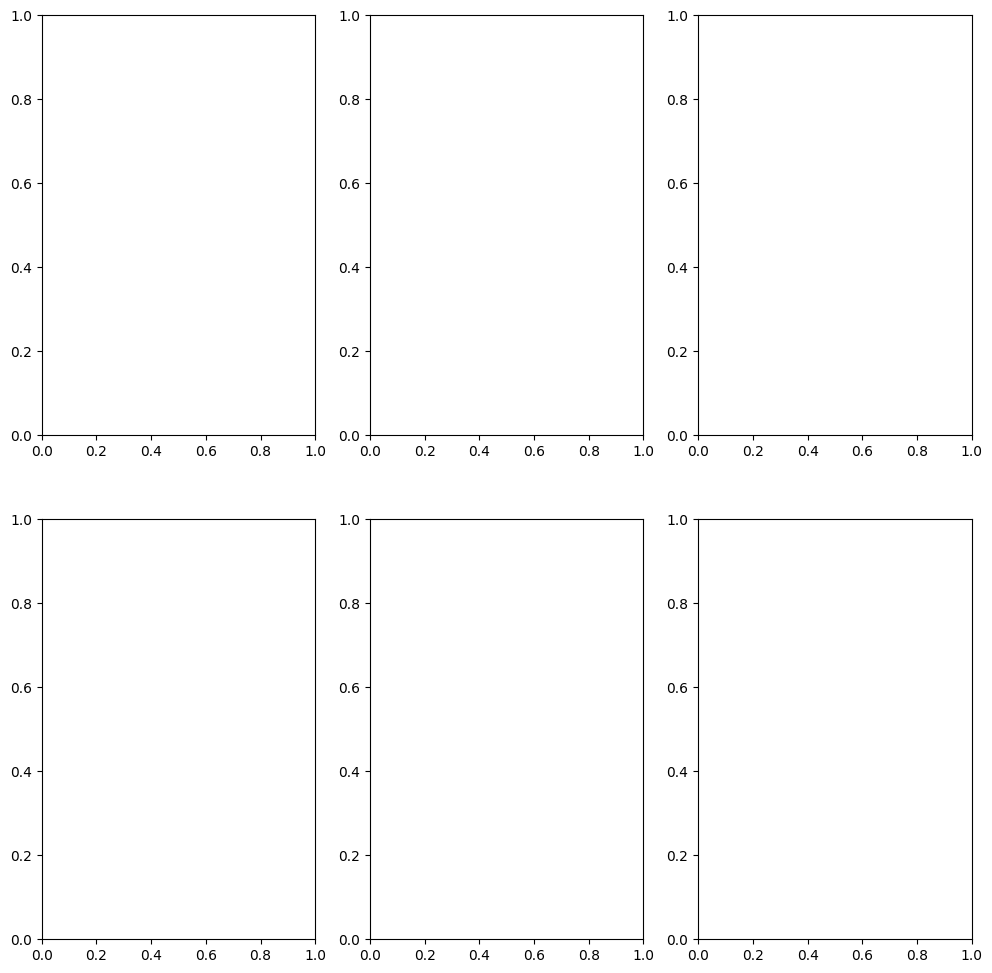

In [15]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 12))
exp.run(num_epochs=EPOCH_MODEL, plot=lambda exp: 
         PlotUtils.plot_images_and_metrics(
             exp, axes, test_dataset_patched, np.random.randint(len(test_dataset_patched)), device))

Chosen index 0
Chosen index 1
Chosen index 2


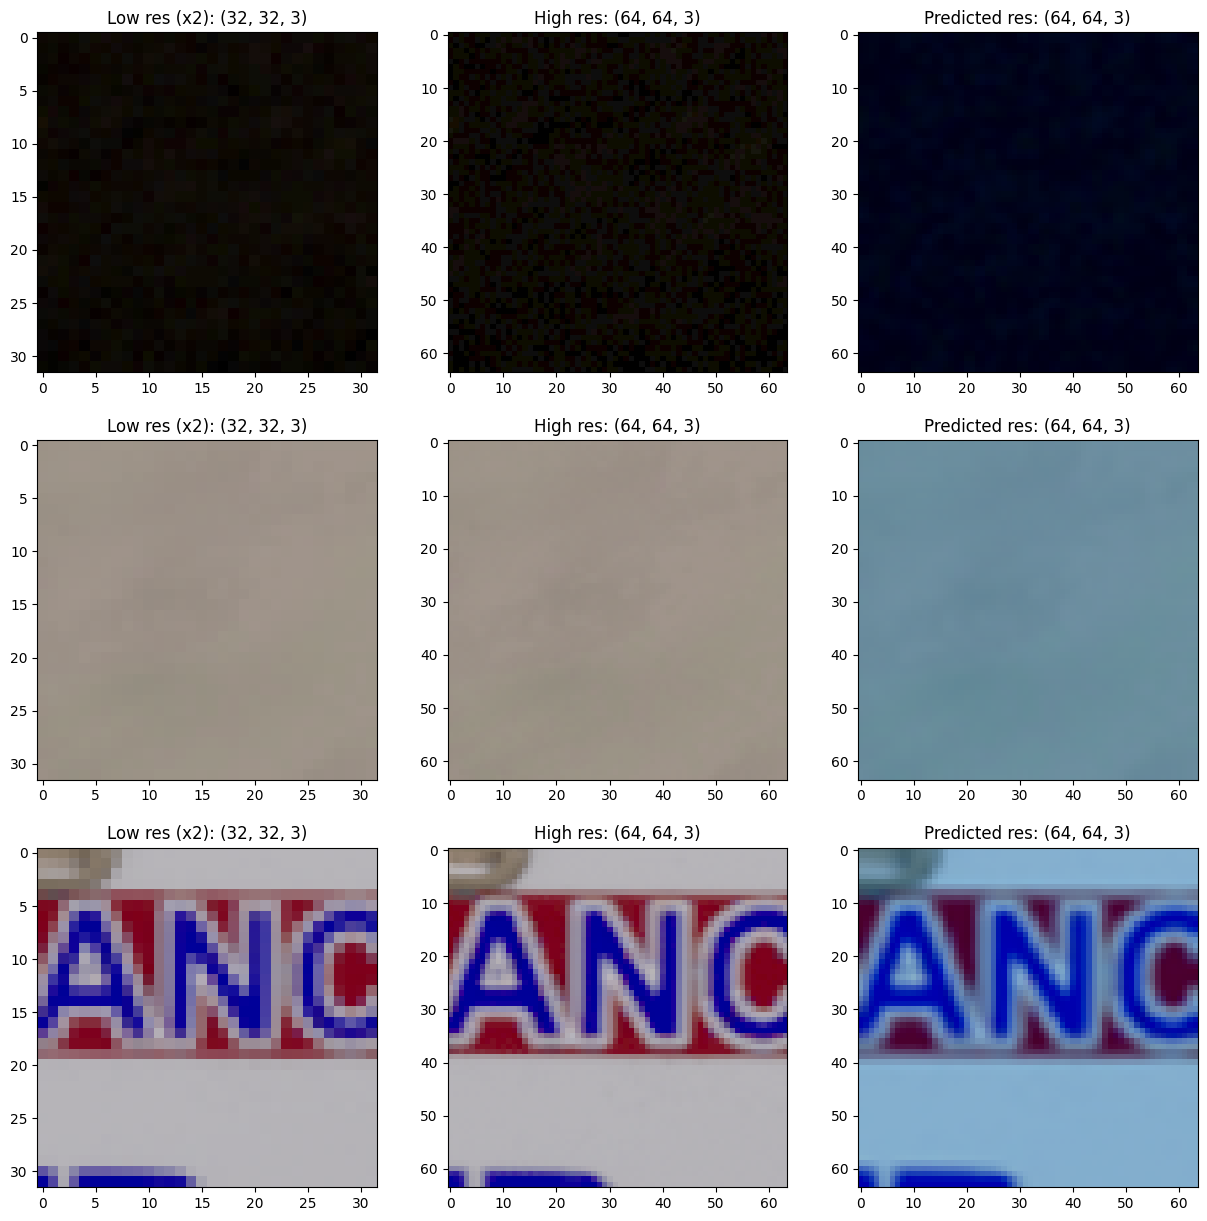

In [ ]:
PlotUtils.plot_images_from_model(exp, test_dataset_patched, device, indices=[0, 1, 2])

Chosen index 0
0.63745886 0.44652224
Chosen index 1
0.6201487 0.438911
Chosen index 2
0.6196033 0.43854097


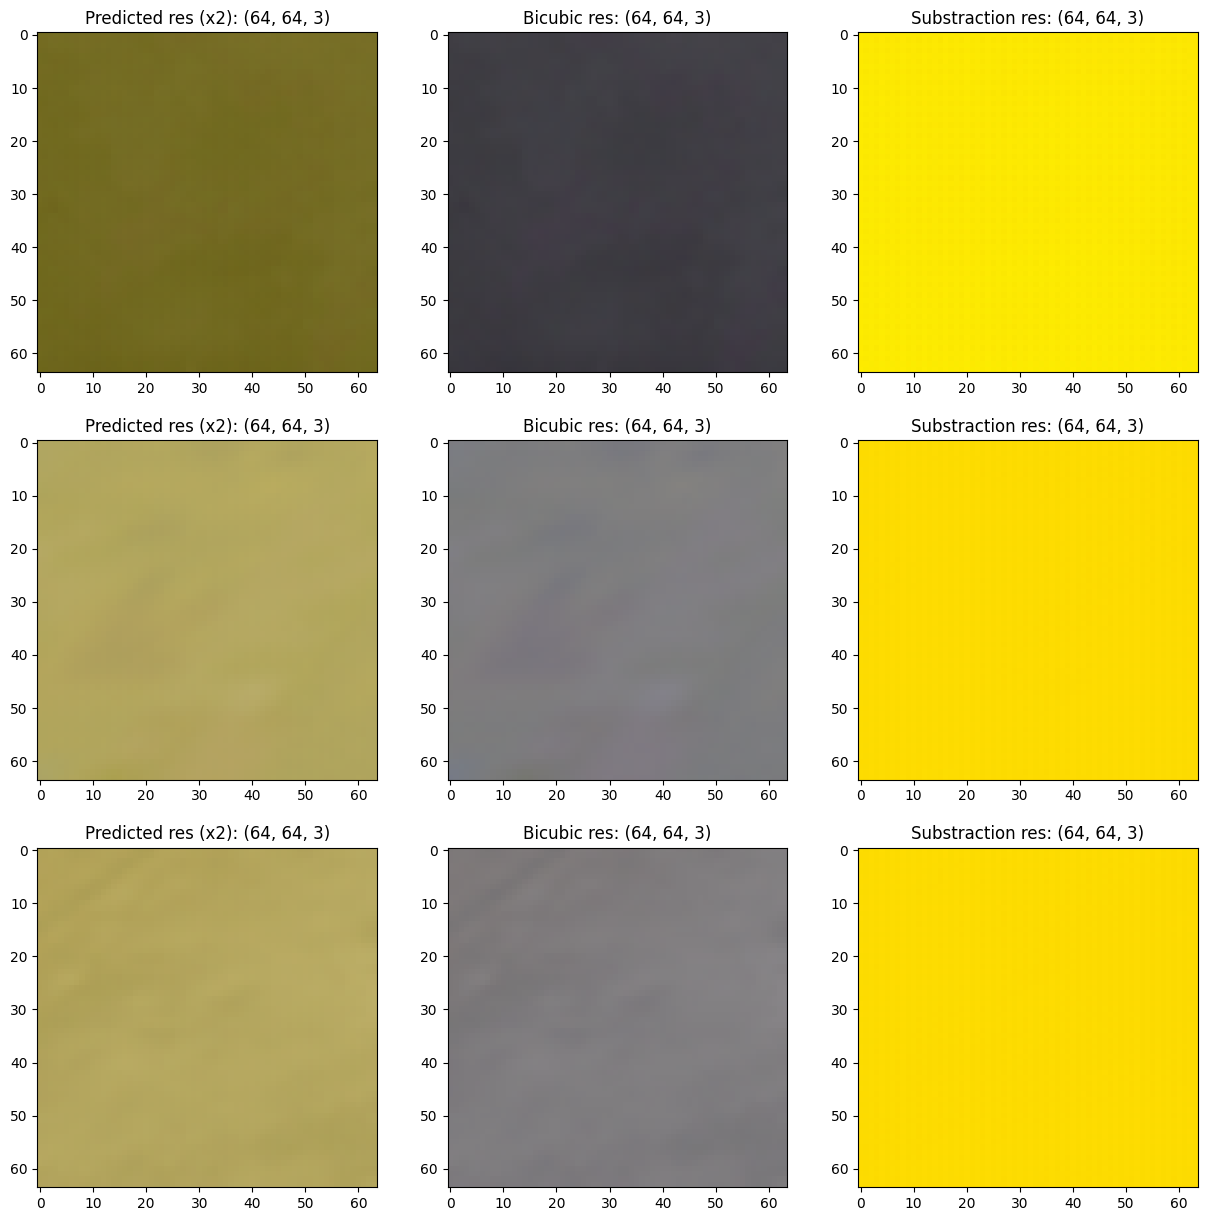

In [ ]:
PlotUtils.plot_predicted_and_bicubic(exp, test_dataset_patched, device, indices=[0, 1, 2])

# Reconstruct image from patch

In [ ]:
index_patch_train = np.random.randint(len(full_train_dataset))
index_patch_test = np.random.randint(len(full_test_dataset))

print("Choose index train", index_patch_train, "Choose index test", index_patch_test)

start_index_patch_train = full_train_dataset.get_index_start_patch(index_patch_train)
start_index_patch_test = full_test_dataset.get_index_start_patch(index_patch_test)

print ("Start index patch train", start_index_patch_train, "Start index patch test", start_index_patch_test)

index_train = full_train_dataset.get_index_for_image(index_patch_train)
index_test = full_test_dataset.get_index_for_image(index_patch_test)

print ("Index train", index_train, "Index test", index_test)

train_low_res, train_high_res = full_train_dataset.get_full_image(index_train)
test_low_res, test_high_res = full_test_dataset.get_full_image(index_test)

high_res = full_train_dataset.high_res_size

pred_high_res1 = PatchImageTool.predict_image_from_dataset_patches(exp, high_res, full_train_dataset, index_patch_train, device)
pred_high_res2 = PatchImageTool.predict_image_from_dataset_patches(exp, high_res, full_test_dataset, index_patch_test, device)

Choose index train 295466 Choose index test 30919
Start index patch train 295200 Start index patch test 30720
Index train 615 Index test 64


ValueError: too many values to unpack (expected 2)

In [ ]:
PlotUtils.show_low_high_predicted([train_low_res], [train_high_res], [pred_high_res1], name="Train")

PlotUtils.show_low_high_predicted([test_low_res], [test_high_res], [pred_high_res2], name="Test")

In [ ]:
pred_high_res1_numpy = torchUtil.tensor_to_numpy(pred_high_res1)
bicubic_image1_numpy = torchUtil.resize_tensor_to_numpy(
    train_low_res, (pred_high_res1_numpy.shape[0], pred_high_res1_numpy.shape[1]))

subtraction_numpy = torchUtil.norm_numpy_image(pred_high_res1_numpy - bicubic_image1_numpy)

PlotUtils.show_predicted_interpolated_subtraction([pred_high_res1_numpy], [bicubic_image1_numpy], [subtraction_numpy], 
                                                  name="Train")

pred_high_res2_numpy = torchUtil.tensor_to_numpy(pred_high_res2)

bicubic_image2_numpy = torchUtil.resize_tensor_to_numpy(test_low_res, 
                                                         (pred_high_res2_numpy.shape[0], 
                                                          pred_high_res2_numpy.shape[1]))


subtraction2_numpy = torchUtil.norm_numpy_image(pred_high_res2_numpy - bicubic_image2_numpy)

PlotUtils.show_predicted_interpolated_subtraction([pred_high_res2_numpy], [bicubic_image2_numpy], [subtraction2_numpy],
                                                   name="Test")


In [ ]:
# Compute the PSNR and SSIM for the predicted image

train_high_res_np = torchUtil.tensor_to_numpy(train_high_res)
test_high_res_np = torchUtil.tensor_to_numpy(test_high_res)

pred_high_res1_np = torchUtil.tensor_to_numpy(pred_high_res1)
pred_high_res2_np = torchUtil.tensor_to_numpy(pred_high_res2)

train_psnr = metrics.peak_signal_noise_ratio(train_high_res_np, pred_high_res1_np)
train_ssim = metrics.structural_similarity(train_high_res_np, pred_high_res1_np,
                                            win_size=7, data_range=1, multichannel=True, channel_axis=2)

test_psnr = metrics.peak_signal_noise_ratio(test_high_res_np, pred_high_res2_np)
test_ssim = metrics.structural_similarity(test_high_res_np, pred_high_res2_np, 
                                          win_size=7, data_range=1, multichannel=True, channel_axis=2)

print("Train PSNR", train_psnr, "Train SSIM", train_ssim)
print("Test PSNR", test_psnr, "Test SSIM", test_ssim)

# Compute the PSNR and SSIM for the bilinear image

train_bicubic_psnr = metrics.peak_signal_noise_ratio(train_high_res_np, bicubic_image1_numpy)
train_bicubic_ssim = metrics.structural_similarity(train_high_res_np, bicubic_image1_numpy, win_size=7, data_range=1, multichannel=True, channel_axis=2)

test_bicubic_psnr = metrics.peak_signal_noise_ratio(test_high_res_np, bicubic_image2_numpy)
test_bicubic_ssim = metrics.structural_similarity(test_high_res_np, bicubic_image2_numpy, win_size=7, data_range=1, multichannel=True, channel_axis=2)

print()
print("Train bilinear PSNR", train_bicubic_psnr, "Train bilinear SSIM", train_bicubic_ssim)
print("Test bilinear PSNR", test_bicubic_psnr, "Test bilinear SSIM", test_bicubic_ssim)

In [ ]:
sub_dataset_size = 10

# Compute the PSNR and SSIM for the predicted image on a subset of the train set
train_psnr, train_ssim = PatchImageTool.compute_metrics_dataset(exp, full_train_dataset, sub_dataset_size, (1920, 1080), device)

# Compute the PSNR and SSIM for the predicted image on a subset of the test set
test_psnr, test_ssim = PatchImageTool.compute_metrics_dataset(exp, full_test_dataset, sub_dataset_size, (1920, 1080), device)

print()
print("PSNR scores for test images, mean : ", test_psnr.mean(), ", var :", test_psnr.var())
print("Average SSIM for test images, mean : ", test_ssim.mean(), ", var :", test_ssim.var())

print("Average PSNR for train images, mean : ", train_psnr.mean(), ", var :", train_psnr.var())
print("Average SSIM for train images, mean : ", train_ssim.mean(), ", var :", train_ssim.var())

In [ ]:
# Test on 20 images from the test set
sub_dataset_size = 20
indices = np.random.choice(len(full_test_dataset), sub_dataset_size, replace=False)
predicted_images = PatchImageTool.predict_images_from_dataset_patches(exp, (1920, 1080), full_test_dataset, indices, device)

In [ ]:
# Show 4 images, real vs predicted

low_res_tensor = []
high_res_tensor = []

for i in range(4):
    index = indices[i]
    image_index = full_test_dataset.get_index_for_image(index)

    low_res, high_res = full_test_dataset.get_full_image(image_index)
    low_res_tensor.append(low_res)
    high_res_tensor.append(high_res)

PlotUtils.show_low_high_predicted(low_res_tensor, high_res_tensor, predicted_images[:len(low_res_tensor)], name="Test")

In [ ]:
# Show 4 images, predicted, bilinear and subtraction

predicted_images_numpy = []
bicubic_images_numpy = []
subtraction_images_numpy = []

for i in range(4):
    index = indices[i]
    image_index = full_test_dataset.get_index_for_image(index)

    low_res, high_res = full_test_dataset.get_full_image(image_index)

    pred_high_res_image = torchUtil.tensor_to_numpy(predicted_images[i])
    bicubic_image = torchUtil.resize_tensor_to_numpy(low_res, (pred_high_res_image.shape[0], pred_high_res_image.shape[1]))

    predicted_images_numpy.append(pred_high_res_image)
    bicubic_images_numpy.append(bicubic_image)
    
    subtraction_image = torchUtil.norm_numpy_image(pred_high_res_image - bicubic_image)
    subtraction_images_numpy.append(subtraction_image)

PlotUtils.show_predicted_interpolated_subtraction(predicted_images_numpy, bicubic_images_numpy, subtraction_images_numpy, 
                                                  name="Test")

In [ ]:
# compute the mean and var psnr and ssim for n images from the test set

batch_size = full_test_dataset.get_number_patch_per_image() * 4

sub_size = 1
sub_dataset_size = int(sub_size * len(full_test_dataset) / full_test_dataset.get_number_patch_per_image())
print("Number of images in full data set part", sub_dataset_size)
test_psnr, test_ssim = PatchImageTool.compute_metrics_dataset_batched(exp, (1920, 1080), full_test_dataset, sub_dataset_size, device, batch_size)

# Compute the PSNR and SSIM for the bilinear image on a subset of the train set

test_bicubic_psnr, test_bicubic_ssim = [], []

for i in range(sub_dataset_size):
    low_res, high_res = full_test_dataset.get_full_image(i)

    low_res_image = torchUtil.tensor_to_numpy(low_res)
    high_res_image = torchUtil.tensor_to_numpy(high_res)

    bicubic_image = torchUtil.resize_tensor_to_numpy(low_res, (high_res_image.shape[0], high_res_image.shape[1]))

    test_bicubic_psnr.append(metrics.peak_signal_noise_ratio(high_res_image, bicubic_image))
    test_bicubic_ssim.append(metrics.structural_similarity(high_res_image, bicubic_image, win_size=7, data_range=1, multichannel=True, channel_axis=2))

# compute the mean and var psnr and ssim for 100 images from the train set

sub_dataset_size = int(sub_size * len(full_train_dataset) / full_train_dataset.get_number_patch_per_image())
print("Number of images in full data set part", sub_dataset_size)
train_psnr, train_ssim = PatchImageTool.compute_metrics_dataset_batched(exp,  (1920, 1080), full_train_dataset, sub_dataset_size, device, batch_size)

train_bicubic_psnr, train_bicubic_ssim = [], []

for i in range(sub_dataset_size):
    low_res, high_res = full_train_dataset.get_full_image(i)

    low_res_image = torchUtil.tensor_to_numpy(low_res)
    high_res_image = torchUtil.tensor_to_numpy(high_res)

    bicubic_image = torchUtil.resize_tensor_to_numpy(low_res, (high_res_image.shape[0], high_res_image.shape[1]))

    train_bicubic_psnr.append(metrics.peak_signal_noise_ratio(high_res_image, bicubic_image))
    train_bicubic_ssim.append(metrics.structural_similarity(high_res_image, bicubic_image, win_size=7, data_range=1, multichannel=True, channel_axis=2))

print("Average PSNR for test images", test_psnr.mean(), "Variance", test_psnr.var())
print("Average SSIM for test images", test_ssim.mean(), "Variance", test_ssim.var())

print("Average PSNR for bicubic test images", np.array(test_bicubic_psnr).mean(), "Variance", np.array(test_bicubic_psnr).var())
print("Average SSIM for bicubic test images", np.array(test_bicubic_ssim).mean(), "Variance", np.array(test_bicubic_ssim).var())

print()

print("Average PSNR for train images", train_psnr.mean(), "Variance", train_psnr.var())
print("Average SSIM for train images", train_ssim.mean(), "Variance", train_ssim.var())

print("Average PSNR for bicubic train images", np.array(train_bicubic_psnr).mean(), "Variance", np.array(train_bicubic_psnr).var())
print("Average SSIM for bicubic train images", np.array(train_bicubic_ssim).mean(), "Variance", np.array(train_bicubic_ssim).var())
